In [1]:
# Dependencies
#> %matplotlib inline
#> from matplotlib import style
#> style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

---
# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

---
# Exploratory Climate Analysis

In [9]:
# Let's first inspect the tables columns
inspector = inspect(engine)

meas_columns = inspector.get_columns('measurement')
print("Measurement:")
for c in meas_columns:
    print(c['name'], c["type"])
    
station_columns = inspector.get_columns('station')
print("\nStations:")
for c in station_columns:
    print(c['name'], c["type"])

Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results


In [12]:
# Calculate the date 1 year ago from the last data point in the database
final_date = session.query(Measurement.date)\
            .order_by(Measurement.date.desc()).first()
print(f"The last date in the dataset is: {final_date[0]}")

start_date = (dt.datetime.strptime(final_date[0],'%Y-%m-%d') 
              - dt.timedelta(days=365)).strftime('%Y-%m-%d')
print(f"And one year prior is: {start_date}")

The last date in the dataset is: 2017-08-23
And one year prior is: 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp)\
            .filter(Measurement.date >= start_date).all()
prcp_query[:3]

[('2016-08-23', 0.0), ('2016-08-24', 0.08), ('2016-08-25', 0.08)]

In [18]:
# Save the query results as a Pandas DataFrame and drop any missing values
prcp_df = pd.DataFrame(prcp_query,columns=['date','precipitation']).dropna()

# Set the index to the date column
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

prcp_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


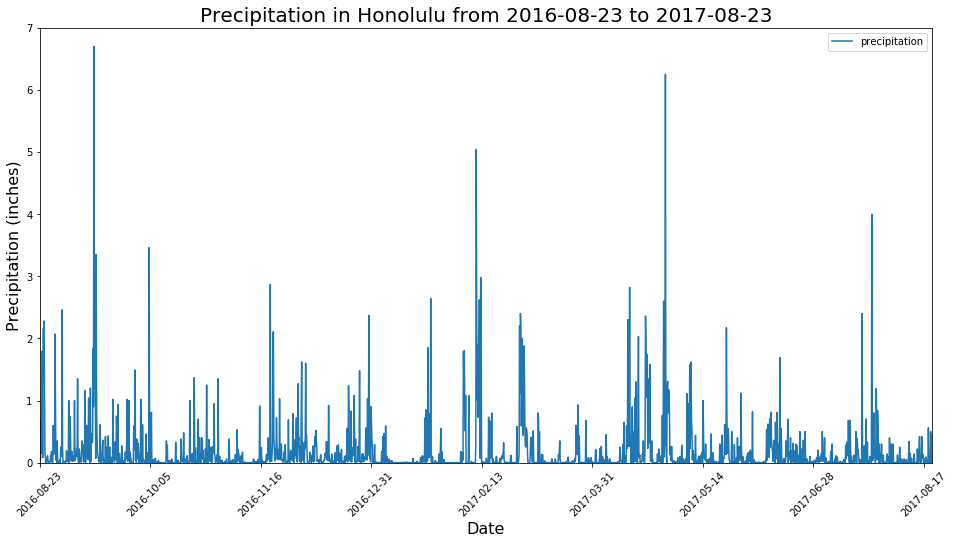

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(16,8), rot=45)
plt.ylim(0,7)
plt.title(f"Precipitation in Honolulu from {start_date} to {final_date[0]}", size=20)
plt.xlabel("Date", size=16)
plt.ylabel("Precipitation (inches)", size=16)
plt.show()

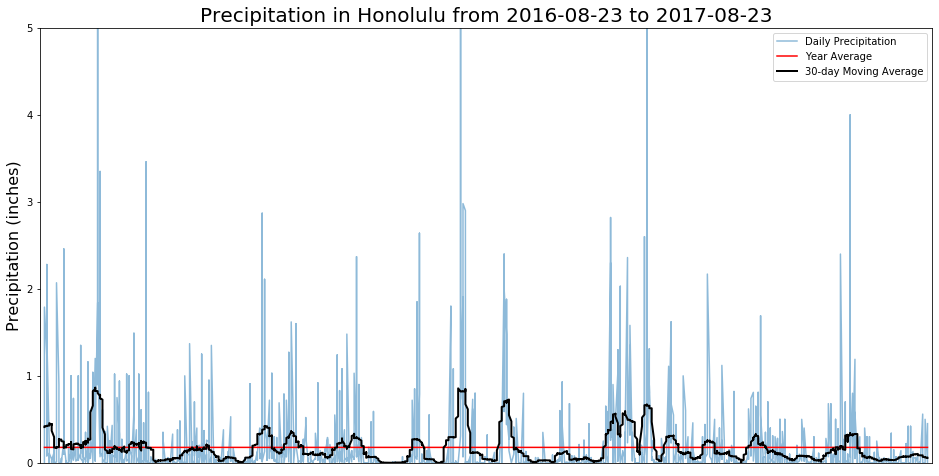

In [83]:
# Just for fun, let's look at the 30-day moving average of rainfall rather than have so many spikes
plt.figure(0,(16,8))
plt.plot(prcp_df.index, prcp_df.precipitation, alpha=0.5, label='Daily Precipitation')
plt.plot(prcp_df.index, [prcp_df.precipitation.mean()]*len(prcp_df), color='red', label='Year Average')
N=30 # Below we use Numpy's convolve to take a running average
plt.plot(prcp_df.index, np.convolve(prcp_df.precipitation, np.ones((N,))/N, mode='same'), 
         color='black', lw=2, label='30-day Moving Average')
plt.xticks([])
plt.xlim(-2,367)
plt.ylim(0,5)
plt.title(f"Precipitation in Honolulu from {start_date} to {final_date[0]}", size=20)
#plt.xlabel("Date", size=16)
plt.ylabel("Precipitation (inches)", size=16)
plt.legend()
plt.show()

In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


---
# Station Analysis

In [85]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
print(f"There are {station_count} stations available in the dataset.")

There are 9 stations available in the dataset.


In [87]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                 .group_by(Measurement.station)\
                 .order_by(func.count(Measurement.station).desc())
station_activity.all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [105]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station
most_active_station = session.query(func.min(Measurement.tobs), 
                                    func.max(Measurement.tobs), 
                                    func.avg(Measurement.tobs))\
                     .filter(Measurement.station == station_activity[0][0])
print(f"The lowest temperature recorded was {most_active_station[0][0]} °F.")
print(f"The highest temperature recorded was {most_active_station[0][1]} °F.")
print(f"The average recorded temperature was {round(most_active_station[0][2],1)} °F.")

The lowest temperature recorded was 54.0 °F.
The highest temperature recorded was 85.0 °F.
The average recorded temperature was 71.7 °F.


In [108]:
# Query the last 12 months of temperature observation data for this station
tobs_query = session.query(Measurement.date, Measurement.tobs)\
            .filter(Measurement.station == station_activity[0][0])\
            .filter(Measurement.date >= start_date).all()
tobs_query[:3]

[('2016-08-23', 77.0), ('2016-08-24', 77.0), ('2016-08-25', 80.0)]

In [123]:
# Save the query results as a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_query, columns=['date','TOBs'])

# Set the index to the station column
tobs_df.set_index('date', inplace=True)

# Sort the dataframe by TOBs
tobs_df = tobs_df.sort_values('TOBs')

tobs_df

,TOBs
date,
2017-02-02,59.0
2017-02-08,59.0
2017-02-09,59.0
2017-04-30,60.0
2017-02-03,60.0
...,...
2017-03-11,81.0
2017-07-29,82.0
2017-07-23,82.0


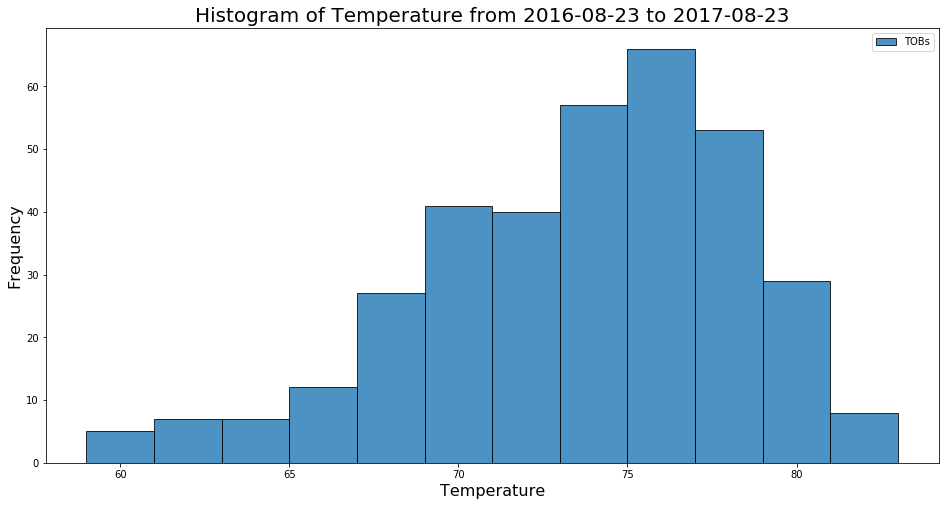

In [129]:
# Plot the histogram
tobs_df.plot(kind= 'hist', bins=12, figsize=(16,8), alpha=0.8, edgecolor='black')
plt.title(f"Histogram of Temperature from {start_date} to {final_date[0]}", size=20)
plt.xlabel("Temperature", size=16)
plt.ylabel("Frequency", size=16)
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
